# Evaluation

In [17]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
import pandas as pd
import pickle
from scipy.stats import pearsonr
from src import utils
import os
import random
import numpy as np

utils.plot_style()
torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)
os.makedirs('plots/', exist_ok=True)

In [18]:
data = torch.load('../../data/simulated/data/large.pt')
results = pickle.load(open('results/final/latents.pkl', 'rb'))
other = pickle.load(open('results/final/other.pkl', 'rb'))

z_inferred = results['z']
n_cells = z_inferred.shape[0]
n_factors = z_inferred.shape[1]

z_inferred = torch.nan_to_num(z_inferred, 0)
z_inferred /= z_inferred.flatten(start_dim=2).max(dim=-1)[0].view(n_cells, n_factors, 1, 1)
z_data = data['z']

w_inferred = results['w']
w_inferred /= w_inferred.max(dim=0)[0].view(1, n_factors)
w_data = data['w']

inds, _ = utils.optimal_assignment(z_data, z_inferred, 1)

z_inferred = z_inferred[:, inds]
w_inferred = w_inferred[:, inds]

w_corr = pearsonr(w_data.flatten(), w_inferred.flatten())[0]
z_corr = pearsonr(z_data.flatten(), z_inferred.flatten())[0]

print('Weight correlation: {}; Factor correlation: {}'.format(round(w_corr, 3), round(z_corr, 3)))

Weight correlation: 0.996; Factor correlation: 0.852


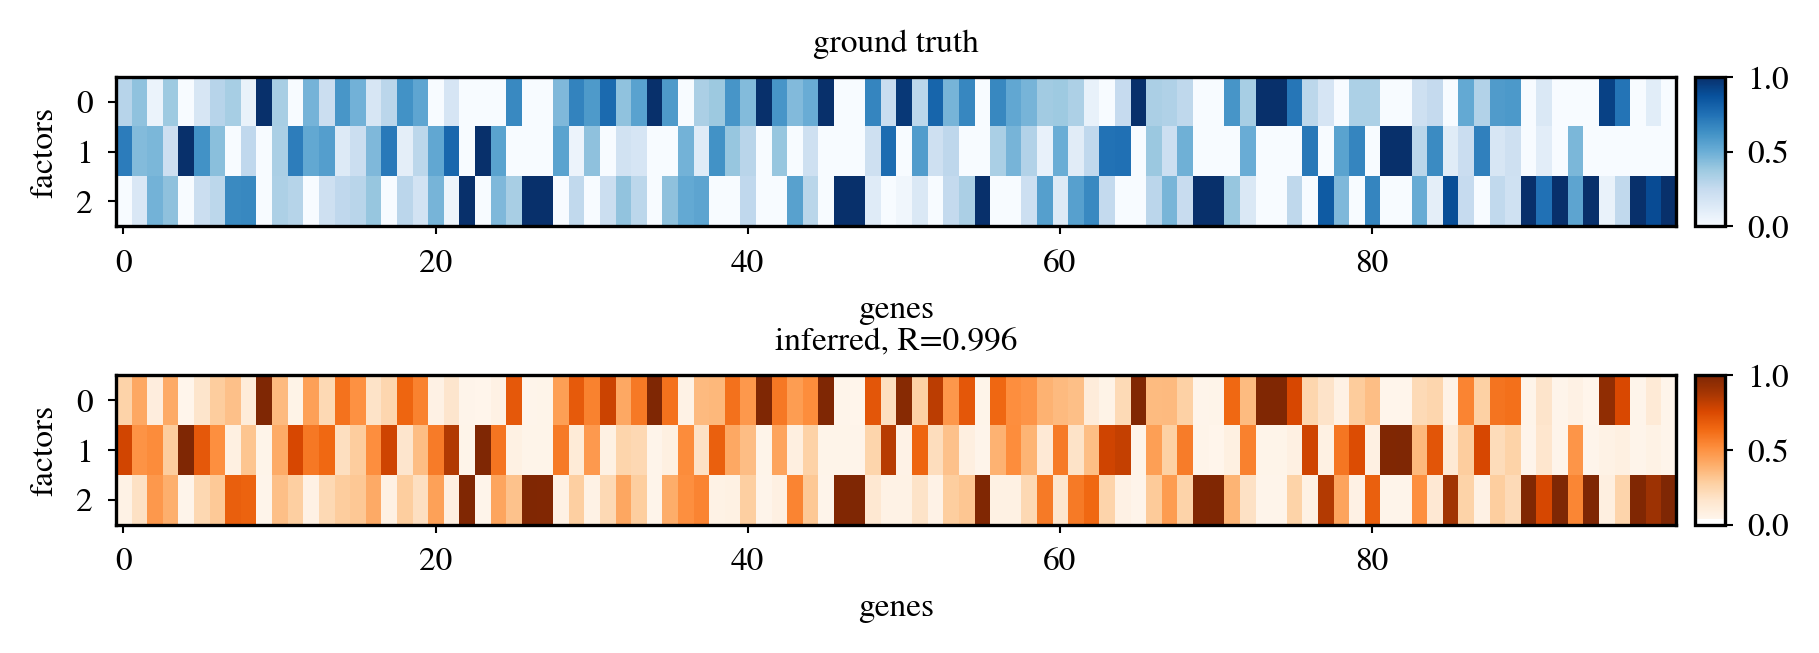

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(6.5, 2), dpi=300)

im = axs[0].matshow(w_data.T, aspect='auto', cmap='Blues')
axs[0].set_title('ground truth')
cbar = plt.colorbar(im, ax=axs[0], aspect=5, pad=0.01)
cbar.ax.set_yticks([0, 0.5, 1])

im = axs[1].matshow(w_inferred.T, aspect='auto', cmap='Oranges')
axs[1].set_title('inferred, R={}'.format(round(w_corr, 3)))
cbar = plt.colorbar(im, ax=axs[1], aspect=5, pad=0.01)
cbar.ax.set_yticks([0, 0.5, 1])

for ax in axs.flatten():
    ax.set_xlabel('genes')
    ax.set_ylabel('factors')
    ax.xaxis.tick_bottom()

plt.tight_layout(pad=0.1)
plt.savefig('plots/weights.svg')

/tmp/ipykernel_69259/1423907756.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Oranges").copy()
  cmap2.set_under(color='grey')


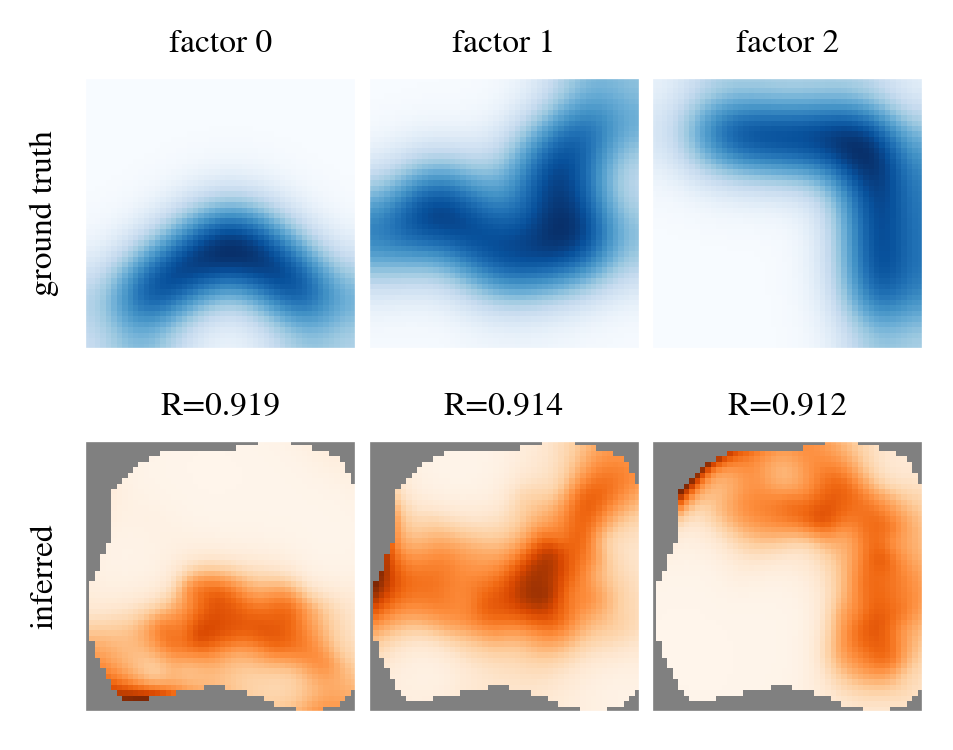

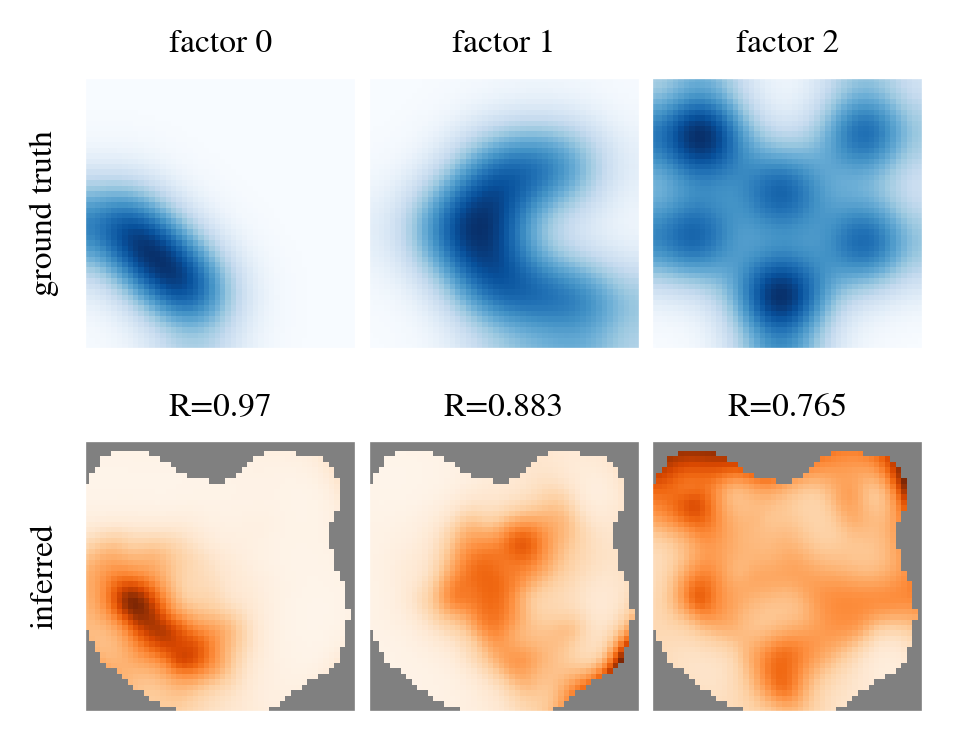

In [20]:
for cell in [3, 4]:
    fig, axs = plt.subplots(2, n_factors, figsize=(3, 2.5), dpi=300)

    cmap1 = mpl.cm.get_cmap('Blues').copy()
    cmap1.set_under(color='grey')
    cmap2 = mpl.cm.get_cmap('Oranges')
    cmap2.set_under(color='grey')

    for factor in range(n_factors):
        im1 = axs[0, factor].matshow(z_data[cell, factor], vmin=0, vmax=1, cmap=cmap1)
        axs[0, factor].set_title('factor {}'.format(factor))
        im2 = axs[1, factor].matshow(z_inferred[cell, factor], vmin=1e-6, vmax=1, cmap=cmap2)
        axs[1, factor].set_title('R={}'.format(round(pearsonr(z_data[cell, factor].flatten(), z_inferred[cell, factor].flatten())[0], 3)))
        
    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_edgecolor('white')

    axs[0, 0].set_ylabel('ground truth')
    axs[1, 0].set_ylabel('inferred')

    plt.tight_layout(pad=0.1)
    plt.savefig('plots/factors_cell_{}.svg'.format(cell))

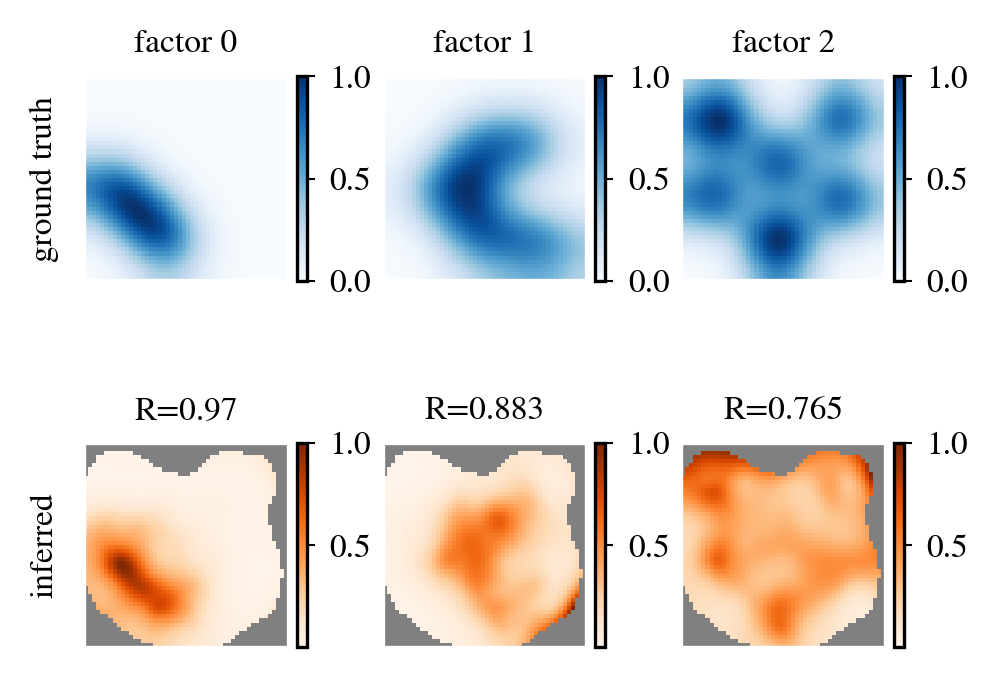

In [21]:
cell = 4

fig, axs = plt.subplots(2, n_factors, figsize=(3.15, 2.5), dpi=300)

cmap = mpl.cm.get_cmap('Blues').copy()
cmap.set_under(color='grey')

for factor in range(n_factors):
    im1 = axs[0, factor].matshow(z_data[cell, factor], vmin=0, vmax=1, cmap='Blues')
    axs[0, factor].set_title('factor {}'.format(factor))
    im2 = axs[1, factor].matshow(z_inferred[cell, factor], vmin=1e-6, vmax=1, cmap='Oranges')
    axs[1, factor].set_title('R={}'.format(round(pearsonr(z_data[cell, factor].flatten(), z_inferred[cell, factor].flatten())[0], 3)))
    plt.colorbar(im1, ax=axs[0, factor], fraction=0.046, pad=0.04, location='right')
    plt.colorbar(im2, ax=axs[1, factor], fraction=0.046, pad=0.04, location='right')
    
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_edgecolor('white')

axs[0, 0].set_ylabel('ground truth')
axs[1, 0].set_ylabel('inferred')

plt.tight_layout(pad=0.1)
plt.savefig('plots/factors_colorbar_cell_{}.svg'.format(cell))

In [22]:
other['runtime'] / 1000 / 60 / 60

24.771475555555558

In [23]:
other['memory_stats'][0][-1]['allocated_bytes.all.peak'] / 1e9

8.457787392